In [69]:
import pandas as pd
fish = pd.read_csv('https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fish.csv')
print(fish)
print(pd.unique(fish['Species']))

    Species  Weight  Length  Diagonal   Height   Width
0     Bream   242.0    25.4      30.0  11.5200  4.0200
1     Bream   290.0    26.3      31.2  12.4800  4.3056
2     Bream   340.0    26.5      31.1  12.3778  4.6961
3     Bream   363.0    29.0      33.5  12.7300  4.4555
4     Bream   430.0    29.0      34.0  12.4440  5.1340
..      ...     ...     ...       ...      ...     ...
154   Smelt    12.2    12.2      13.4   2.0904  1.3936
155   Smelt    13.4    12.4      13.5   2.4300  1.2690
156   Smelt    12.2    13.0      13.8   2.2770  1.2558
157   Smelt    19.7    14.3      15.2   2.8728  2.0672
158   Smelt    19.9    15.0      16.2   2.9322  1.8792

[159 rows x 6 columns]
['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


In [70]:
# 특성 데이터화
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

# 타겟 설정
fish_target = fish['Species'].to_numpy()

# 훈련 세트 데스트 세트 나누기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

# 데이터 전처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)


In [71]:
# k -최근접 이웃 분류
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target), kn.score(test_scaled, test_target))

0.8907563025210085 0.85


In [72]:
# predict_proba() : 클래스별 확률값 반환
print(kn.classes_) # kn에서는 알파벳 순서로 재배치됨

import numpy as np
proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=4))

# 4번째 클래스의 최근접 이웃의 클래스
distances, indexes = kn.kneighbors(test_scaled[3:4]) # 넘파이는 2차원 배열이 필요
print(train_target[indexes])


['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]
[['Roach' 'Perch' 'Perch']]


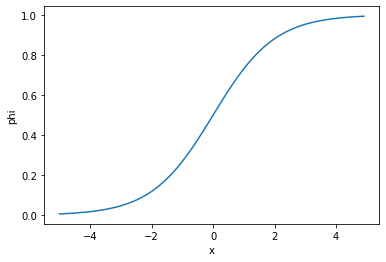

In [73]:
# 로지스틱 함수(시그모이드 함수) : 모든 값이 0부터 1 사이에 존재하여 확률 사용 시 활용
import matplotlib.pyplot as plt
z = np.arange(-5, 5, 0.1)
phi = 1 / (1 + np.exp(-z)) # np.exp() : 지수함수 계산
plt.plot(z, phi)
plt.xlabel('x')
plt.ylabel('phi')
plt.show()

In [74]:
# 불리언 인덱싱
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]])

bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

# 로지스틱 회귀
# z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)
print(lr.predict(train_bream_smelt[:5])) # 5번째까지의 예상 값
print(lr.classes_) # 클래스
print(lr.predict_proba(train_bream_smelt[:5])) # 5번째까지의 예상 확률
print(lr.coef_, lr.intercept_) # 로지스틱 회귀 모델의 계수 (a,b,c,e,f)

# z 값 계산
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

# z 값을 시그모이드 함수에 통과시켜 확률 구하기
from scipy.special import expit # expit() = 로지스틱(시그모이드) 함수
print(expit(decisions)) # 두번째 열과 동일

['A' 'C']
['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']
['Bream' 'Smelt']
[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]
[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]
[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]
[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


In [75]:
# C = 로지스틱에서 규제를 제어하는 매개변수, 높을수록 완화
# max_iter= 를 정의하여 반복 횟수를 지정해줄 수 있다.
lr = LogisticRegression(max_iter= 1000, C= 20)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target), lr.score(test_scaled, test_target))

# 테스트 샘플 5개에 대한 예측
print(lr.predict(test_scaled[:5]))

# 예측에 대한 확률
print(lr.classes_)
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

0.9327731092436975 0.925
['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']
['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [79]:
# 소프트맥스 함수: 여러 개의 선형 방정식의 출력 값을 0~1 사이로 압축하고, 합이 1이 되도록 하는 함수
decisions = lr.decision_function(test_scaled[:5])
print(np.round(decisions, decimals=2), end= '\n\n') # z 값이 클래스마다 생성됨

from scipy.special import softmax
proba = softmax(decisions, axis=1) # axis를 지정 안하면 배열 전체에 대한 소프트 맥스 계산
print(np.round(proba, decimals=3))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]
